<a href="https://colab.research.google.com/github/getmeaname/lstm-stock-prediction/blob/main/Stock_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Requirements
!pip install yahoo_fin
!pip install tensorflow

In [13]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Data preparation
from yahoo_fin import stock_info as si
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.losses import Huber

In [14]:
# SETTINGS

# Window size or the sequence length, (1 week) people don't trade on weekends
N_STEPS = 7

# Lookup steps, Upcoming days of upto 5. i.e (1 week)
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK_LIST = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NVDA']

# Current date and previous 3 years from the current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [15]:
# Function to fetch data for multiple stocks
def load_data(stocks, start_date, end_date, interval='1d'):
    data = {}
    for stock in stocks:
        df = si.get_data(stock, start_date=start_date, end_date=end_date, index_as_date=True, interval=interval)
        data[stock] = df
    return data

# Load data for multiple stocks
stocks_data = load_data(STOCK_LIST, start_date=date_3_years_back, end_date=date_now)
google_stocks = pd.DataFrame(stocks_data['GOOG'])
apple_stocks = pd.DataFrame(stocks_data['AAPL'])
microsoft_stocks = pd.DataFrame(stocks_data['MSFT'])
amazon_stocks = pd.DataFrame(stocks_data['AMZN'])
Nvidia_stocks = pd.DataFrame(stocks_data['NVDA'])
all_stocks_df = pd.concat(stocks_data.values())
results_in_df = pd.DataFrame(all_stocks_df)

# Displays the output in a neat table format
# display(apple_stocks)
# display(microsoft_stocks)
# display(amazon_stocks)
# display(google_stocks)
display(results_in_df)


,open,high,low,close,adjclose,volume,ticker
2021-02-16,135.490005,136.009995,132.789993,133.190002,130.907059,80576300,AAPL
2021-02-17,131.250000,132.220001,129.470001,130.839996,128.597351,97918500,AAPL
2021-02-18,129.199997,130.000000,127.410004,129.710007,127.486732,96856700,AAPL
2021-02-19,130.240005,130.710007,128.800003,129.869995,127.644005,87668800,AAPL
2021-02-22,128.009995,129.720001,125.599998,126.000000,123.840317,103916400,AAPL
...,...,...,...,...,...,...,...
2024-02-16,741.000000,744.020020,725.010010,726.130005,726.130005,49391800,NVDA
2024-02-20,719.469971,719.559998,677.340027,694.520020,694.520020,70483300,NVDA
2024-02-21,680.059998,688.880005,662.479980,674.719971,674.719971,69029800,NVDA
2024-02-22,750.250000,785.750000,742.200012,785.380005,785.380005,86510000,NVDA


# Closing Price

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

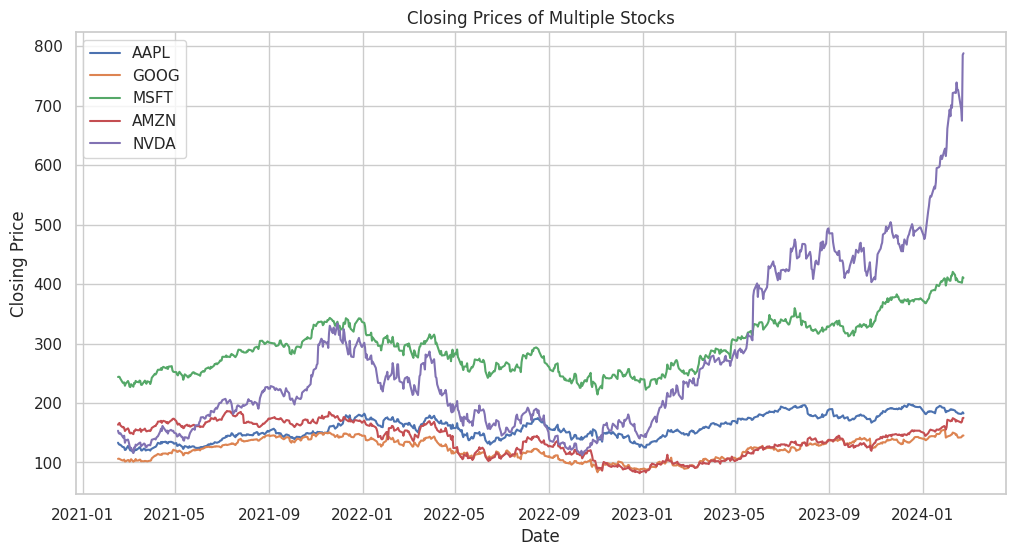

In [16]:
# Plotting closing prices for each stock
plt.figure(figsize=(12, 6))
for ticker in results_in_df['ticker'].unique():
    stock_data = results_in_df[results_in_df['ticker'] == ticker]
    plt.plot(stock_data.index, stock_data['close'], label=ticker)

plt.title('Closing Prices of Multiple Stocks')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# **Volume of Sales**
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

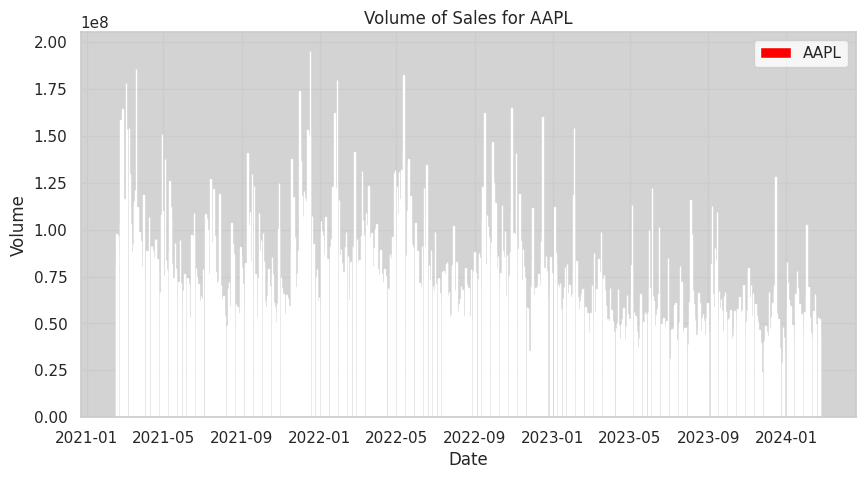

<Figure size 640x480 with 0 Axes>

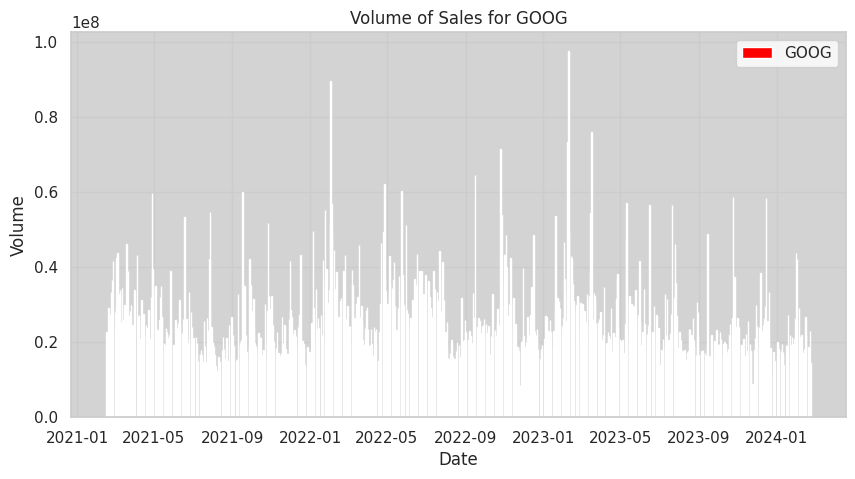

<Figure size 640x480 with 0 Axes>

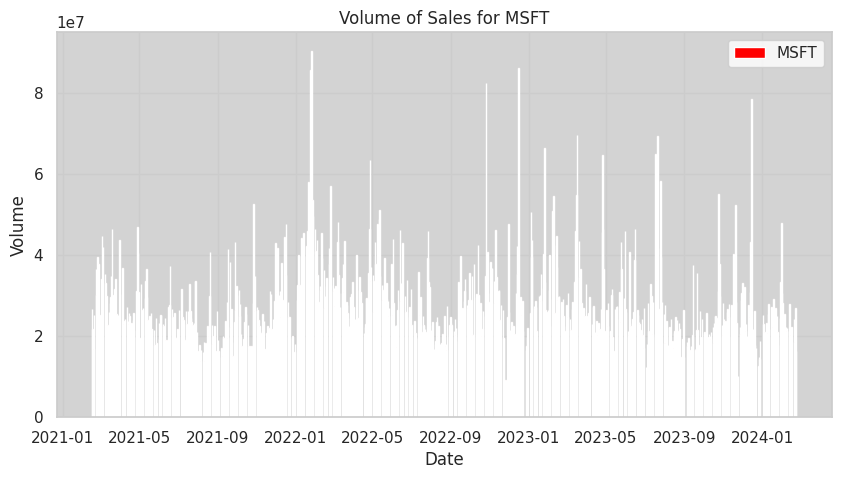

<Figure size 640x480 with 0 Axes>

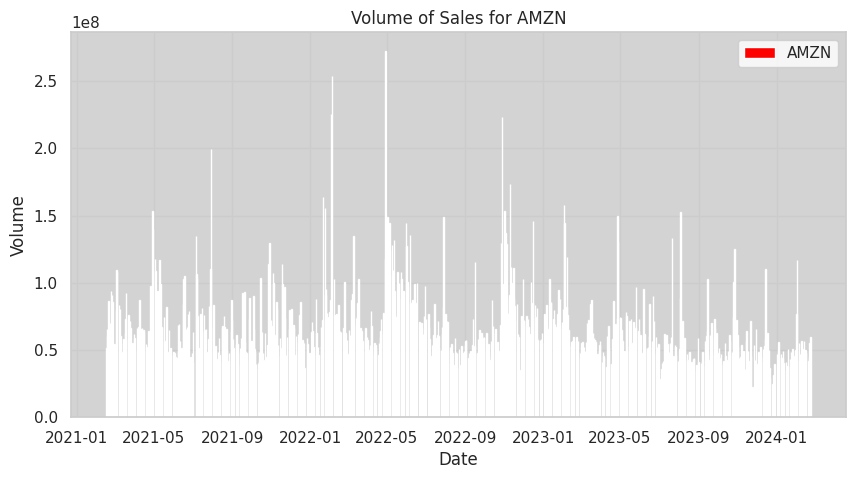

<Figure size 640x480 with 0 Axes>

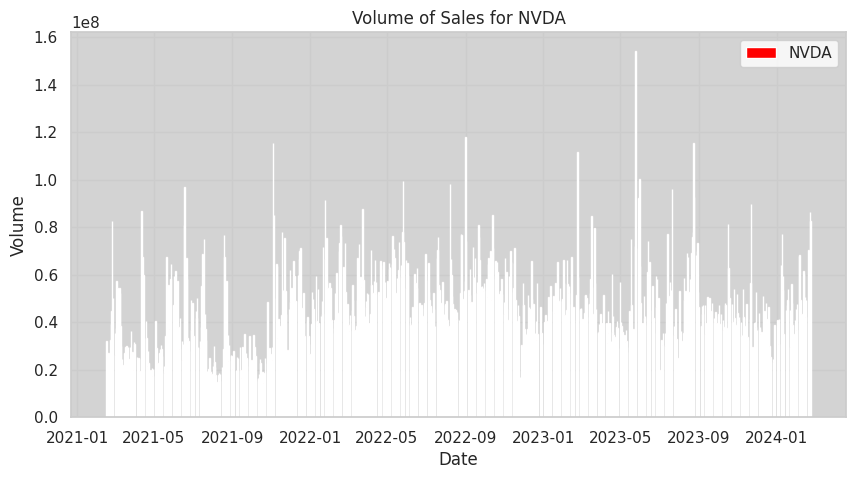

<Figure size 640x480 with 0 Axes>

In [17]:
for stock, df in stocks_data.items():
    plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
    plt.bar(df.index, df['volume'], label=stock, color='red')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.title(f'Volume of Sales for {stock}')
    plt.legend()
    plt.gca().set_facecolor('lightgray')  # Set the background color
    plt.show()
    plt.tight_layout()

# Moving Averages of various stocks in interval of 10, 20, 50 days.

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 days, 50 days, or any time period the trader chooses.

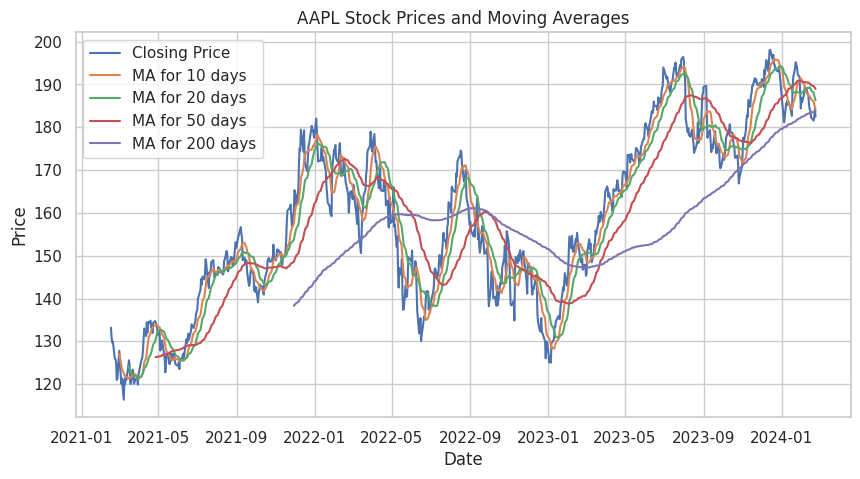

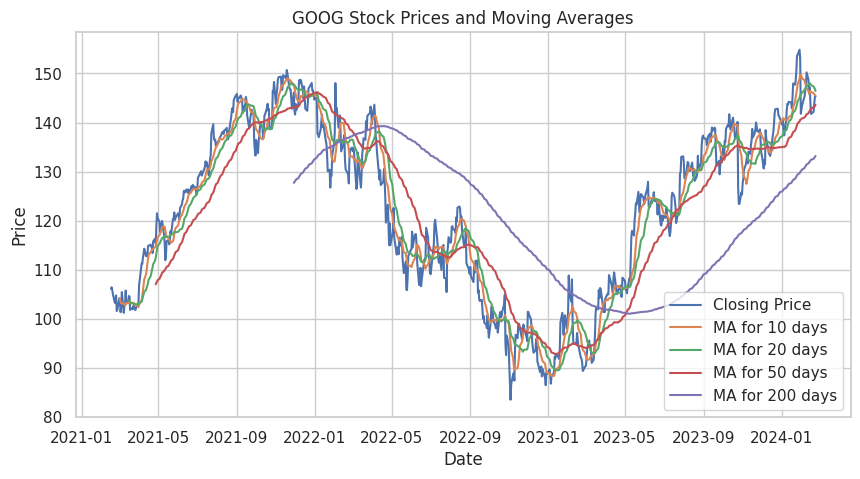

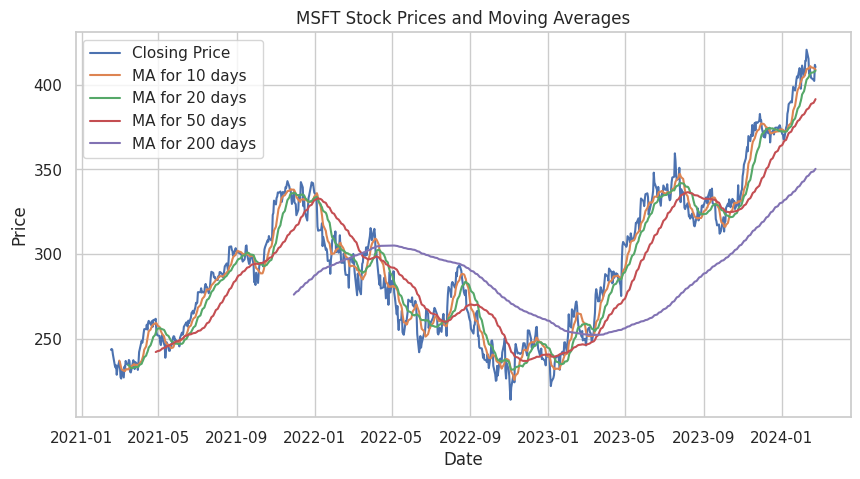

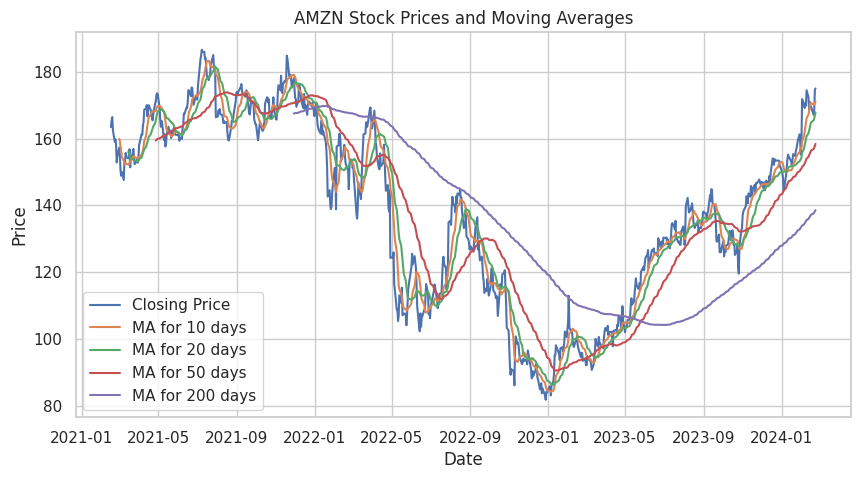

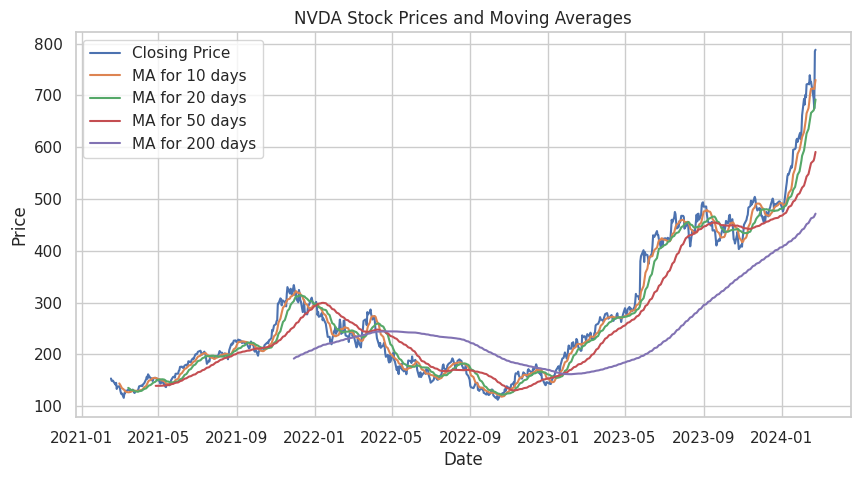

In [18]:
for stock, df in stocks_data.items():
    df['MA10'] = df['close'].rolling(window=10).mean()
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA50'] = df['close'].rolling(window=50).mean()
    df['MA200'] = df['close'].rolling(window=200).mean()

    # Plotting the closing prices and moving averages
    plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
    plt.plot(df.index, df['close'], label='Closing Price')
    plt.plot(df.index, df['MA10'], label='MA for 10 days')
    plt.plot(df.index, df['MA20'], label='MA for 20 days')
    plt.plot(df.index, df['MA50'], label='MA for 50 days')
    plt.plot(df.index, df['MA200'], label='MA for 200 days')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{stock} Stock Prices and Moving Averages')
    plt.legend()
    plt.show()


# What was the daily return of the stock on average?

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the every stock.

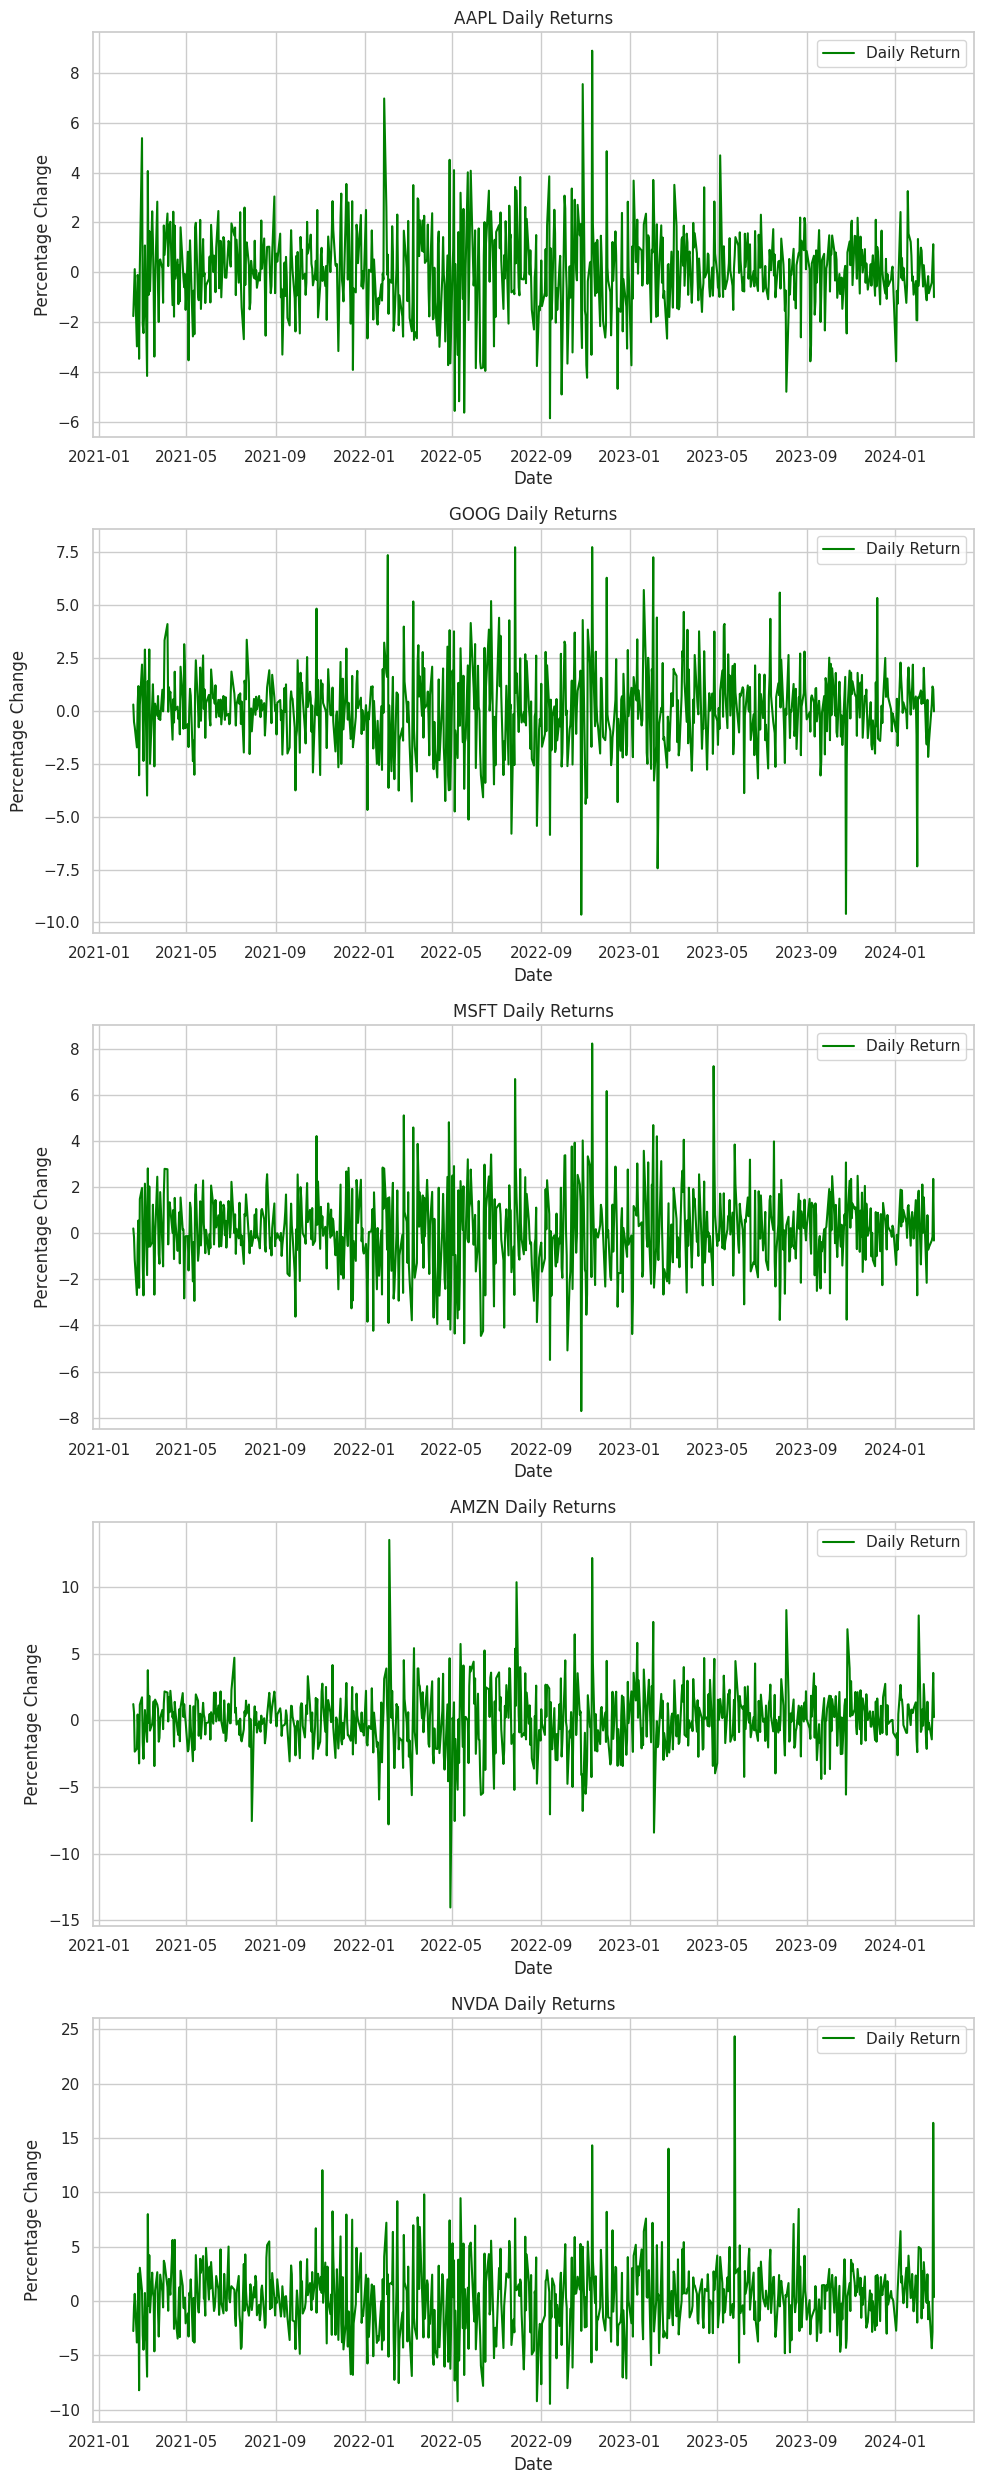

In [19]:
# Create a subplot with multiple axes in a vertical layout
fig, axes = plt.subplots(len(stocks_data), 1, figsize=(10, 5 * len(stocks_data)))

# Display the daily returns for each stock
for (stock, df), ax in zip(stocks_data.items(), axes):
    df['Daily_Return'] = df['close'].pct_change() * 100  # Calculate daily percentage change

    # Plotting the daily returns
    ax.plot(df.index, df['Daily_Return'], label='Daily Return', color='green')

    ax.set_xlabel('Date')
    ax.set_ylabel('Percentage Change')
    ax.set_title(f'{stock} Daily Returns')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots using IPython display method
display(HTML("<h2>Daily Returns for Each Stock</h2>"))
plt.show()

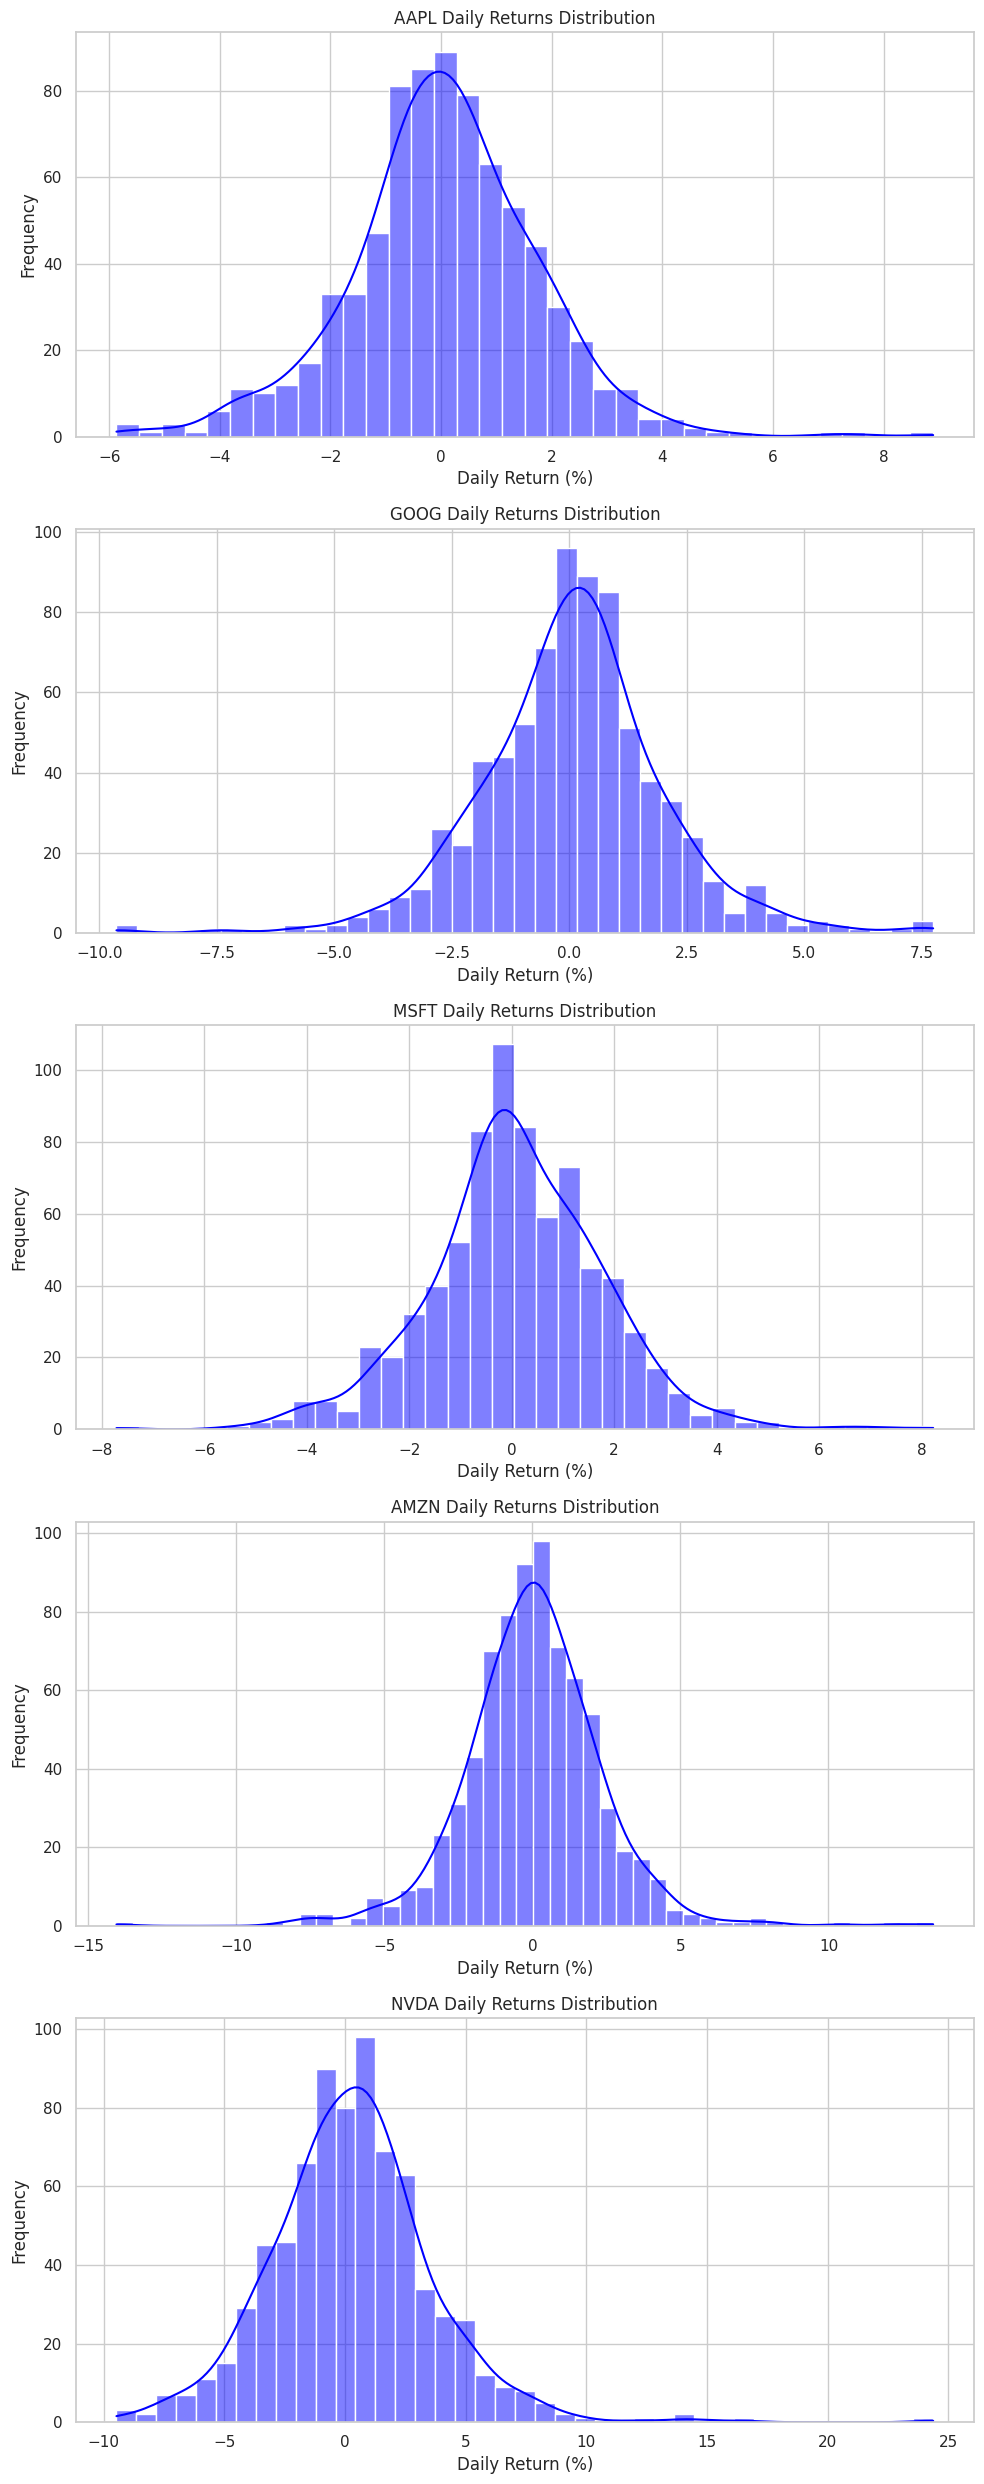

In [20]:
# Create a subplot with multiple axes
fig, axes = plt.subplots(len(stocks_data), 1, figsize=(10, 5 * len(stocks_data)))

# Calculate daily returns for each stock and plot
for (stock, df), ax in zip(stocks_data.items(), axes):
    df['Daily_Return'] = df['close'].pct_change() * 100  # Calculate daily percentage change

    # Plotting histogram and KDE plot for daily returns
    sns.histplot(df['Daily_Return'].dropna(), kde=True, color='blue', ax=ax)

    ax.set_xlabel('Daily Return (%)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{stock} Daily Returns Distribution')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Analyse the correlation btw stocks.
We compare and contrast the correlation between different stocks closing price using a heatmap.

,AAPL,GOOG,MSFT,AMZN,NVDA
2021-02-16,133.190002,106.095001,243.699997,163.447495,153.302505
2021-02-17,130.839996,106.415497,244.199997,165.432007,149.059998
2021-02-18,129.710007,105.860001,243.789993,166.411499,148.289993
2021-02-19,129.869995,105.056999,240.970001,162.494995,149.264999
2021-02-22,126.000000,103.244003,234.509995,159.037003,143.557495
...,...,...,...,...,...
2024-02-16,182.309998,141.759995,404.059998,169.509995,726.130005
2024-02-20,181.559998,142.199997,402.790009,167.080002,694.520020
2024-02-21,182.320007,143.839996,402.179993,168.589996,674.719971
2024-02-22,184.369995,145.320007,411.649994,174.580002,785.380005


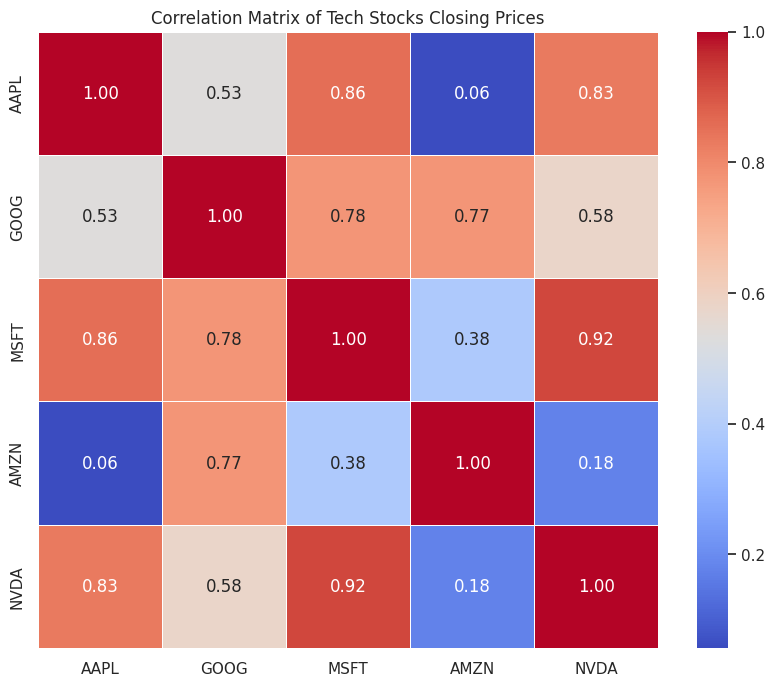

In [21]:
def load_closing_prices(stocks, start_date, end_date, interval='1d'):
    closing_prices = pd.DataFrame()

    for stock in stocks:
        df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)['close'].to_frame(name=stock)
        closing_prices = pd.concat([closing_prices, df], axis=1)

    return closing_prices

# Load closing prices for tech stocks
tech_closing_prices = load_closing_prices(STOCK_LIST, start_date=date_3_years_back, end_date=date_now)
display(tech_closing_prices)
# Calculate the correlation matrix
correlation_matrix = tech_closing_prices.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Tech Stocks Closing Prices')
plt.show()

# Correlation Analysis of Stocks

In this analysis, we explore the correlation between different stocks using joint plots. We specifically focus on identifying stocks that are positively and negatively correlated, considering only correlations of 0.75 and above.



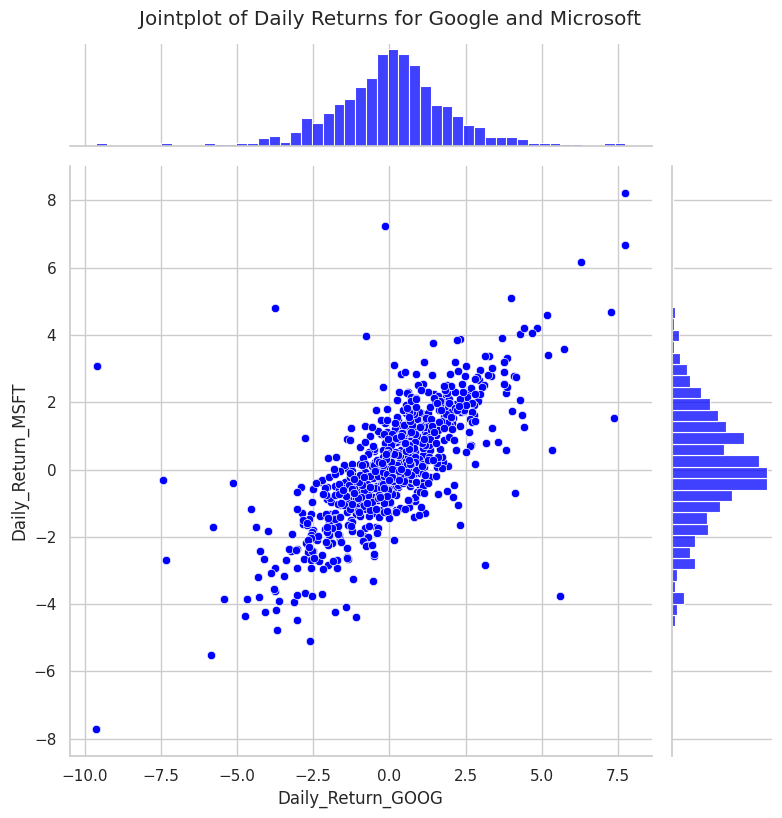

In [22]:
# Function to fetch data for a single stock
def load_data(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)
    return df

# Load data for Google and Microsoft
google_data = load_data('GOOG', start_date=date_3_years_back, end_date=date_now)
microsoft_data = load_data('MSFT', start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns for each stock
google_data['Daily_Return_GOOG'] = google_data['close'].pct_change() * 100
microsoft_data['Daily_Return_MSFT'] = microsoft_data['close'].pct_change() * 100

# Use jointplot to compare daily returns
sns.set(style="whitegrid")
sns.jointplot(x='Daily_Return_GOOG', y='Daily_Return_MSFT', data=pd.concat([google_data, microsoft_data]),
              kind='scatter', height=8, color='blue')
plt.suptitle('Jointplot of Daily Returns for Google and Microsoft', y=1.02)
plt.show()

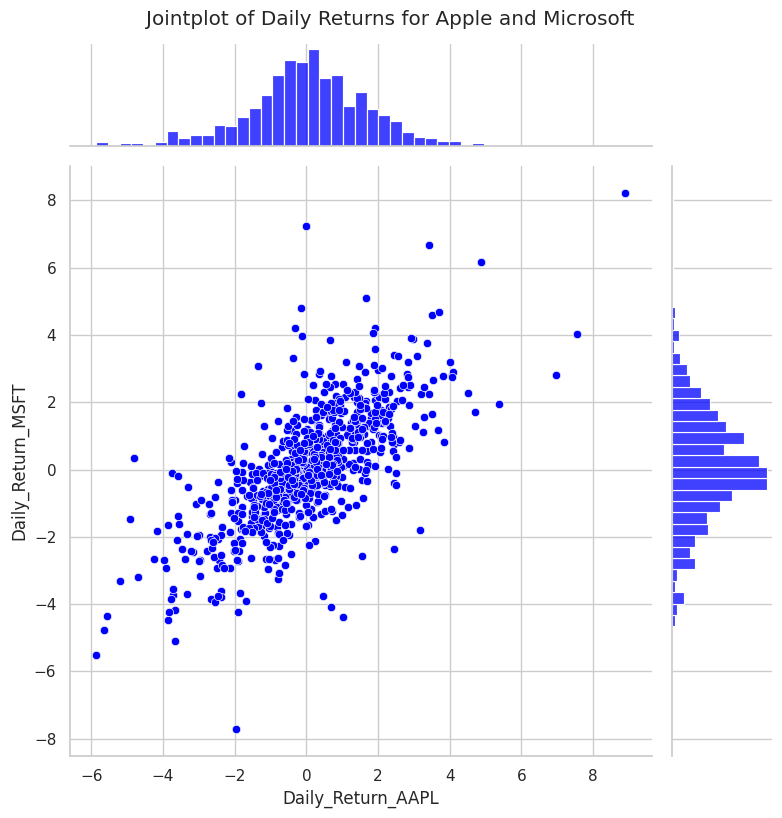

In [23]:
# Function to fetch data for a single stock
def load_data(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)
    return df

# Load data for Google and Microsoft
google_data = load_data('AAPL', start_date=date_3_years_back, end_date=date_now)
microsoft_data = load_data('MSFT', start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns for each stock
google_data['Daily_Return_AAPL'] = google_data['close'].pct_change() * 100
microsoft_data['Daily_Return_MSFT'] = microsoft_data['close'].pct_change() * 100

# Use jointplot to compare daily returns
sns.set(style="whitegrid")
sns.jointplot(x='Daily_Return_AAPL', y='Daily_Return_MSFT', data=pd.concat([google_data, microsoft_data]),
              kind='scatter', height=8, color='blue')
plt.suptitle('Jointplot of Daily Returns for Apple and Microsoft', y=1.02)
plt.show()

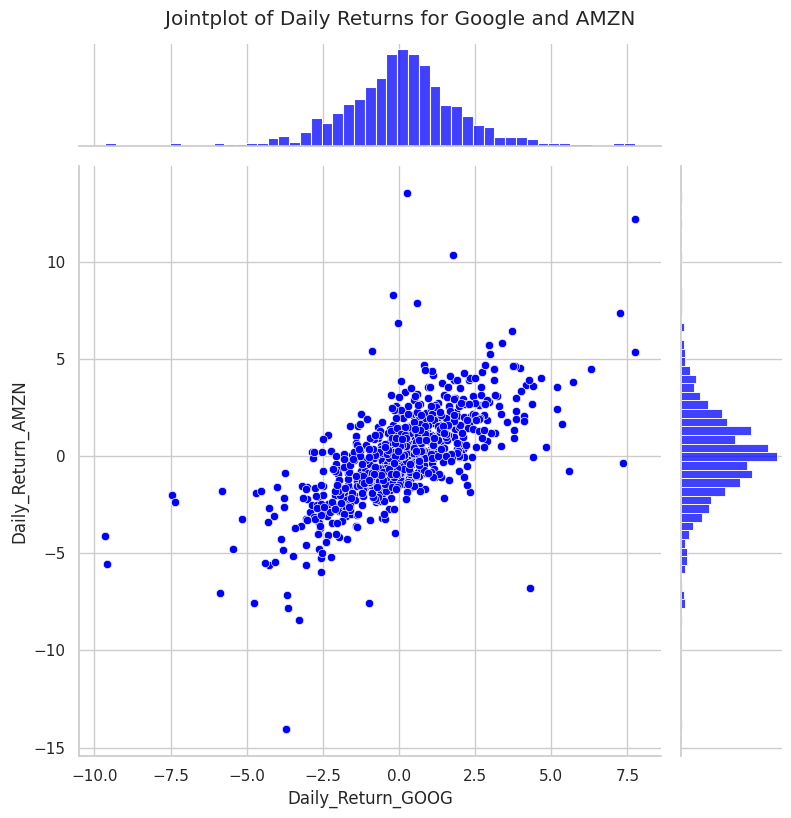

In [24]:
# Function to fetch data for a single stock
def load_data(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)
    return df

# Load data for Google and Microsoft
google_data = load_data('GOOG', start_date=date_3_years_back, end_date=date_now)
microsoft_data = load_data('AMZN', start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns for each stock
google_data['Daily_Return_GOOG'] = google_data['close'].pct_change() * 100
microsoft_data['Daily_Return_AMZN'] = microsoft_data['close'].pct_change() * 100

# Use jointplot to compare daily returns
sns.set(style="whitegrid")
sns.jointplot(x='Daily_Return_GOOG', y='Daily_Return_AMZN', data=pd.concat([google_data, microsoft_data]),
              kind='scatter', height=8, color='blue')
plt.suptitle('Jointplot of Daily Returns for Google and AMZN', y=1.02)
plt.show()

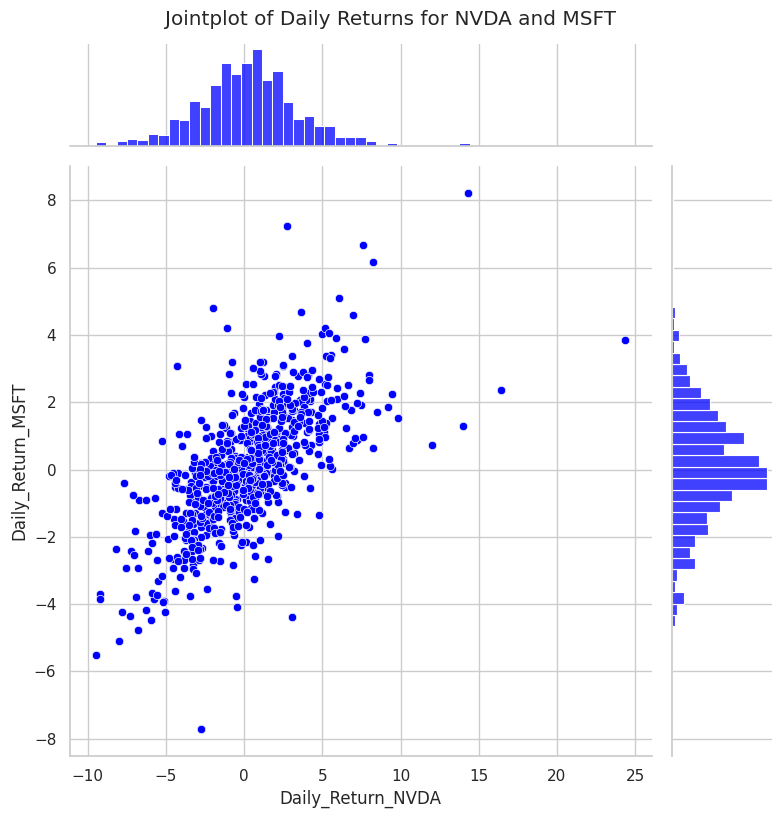

In [25]:
# Function to fetch data for a single stock
def load_data(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)
    return df

# Load data for Google and Microsoft
google_data = load_data('NVDA', start_date=date_3_years_back, end_date=date_now)
microsoft_data = load_data('MSFT', start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns for each stock
google_data['Daily_Return_NVDA'] = google_data['close'].pct_change() * 100
microsoft_data['Daily_Return_MSFT'] = microsoft_data['close'].pct_change() * 100

# Use jointplot to compare daily returns
sns.set(style="whitegrid")
sns.jointplot(x='Daily_Return_NVDA', y='Daily_Return_MSFT', data=pd.concat([google_data, microsoft_data]),
              kind='scatter', height=8, color='blue')
plt.suptitle('Jointplot of Daily Returns for NVDA and MSFT', y=1.02)
plt.show()

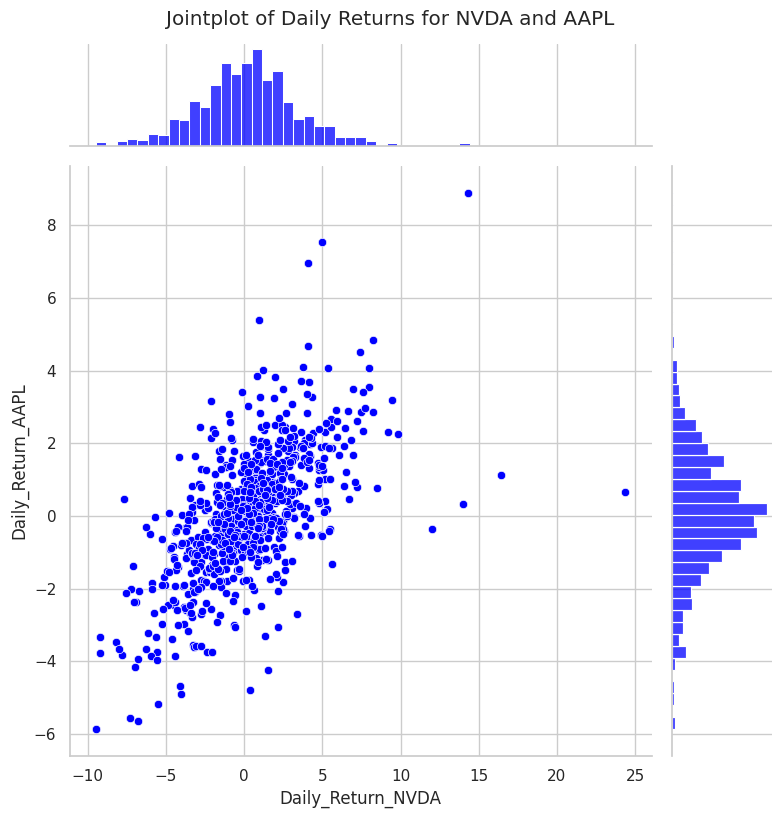

In [26]:
# Function to fetch data for a single stock
def load_data(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)
    return df

# Load data for Google and Microsoft
google_data = load_data('NVDA', start_date=date_3_years_back, end_date=date_now)
microsoft_data = load_data('AAPL', start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns for each stock
google_data['Daily_Return_NVDA'] = google_data['close'].pct_change() * 100
microsoft_data['Daily_Return_AAPL'] = microsoft_data['close'].pct_change() * 100

# Use jointplot to compare daily returns
sns.set(style="whitegrid")
sns.jointplot(x='Daily_Return_NVDA', y='Daily_Return_AAPL', data=pd.concat([google_data, microsoft_data]),
              kind='scatter', height=8, color='blue')
plt.suptitle('Jointplot of Daily Returns for NVDA and AAPL', y=1.02)
plt.show()

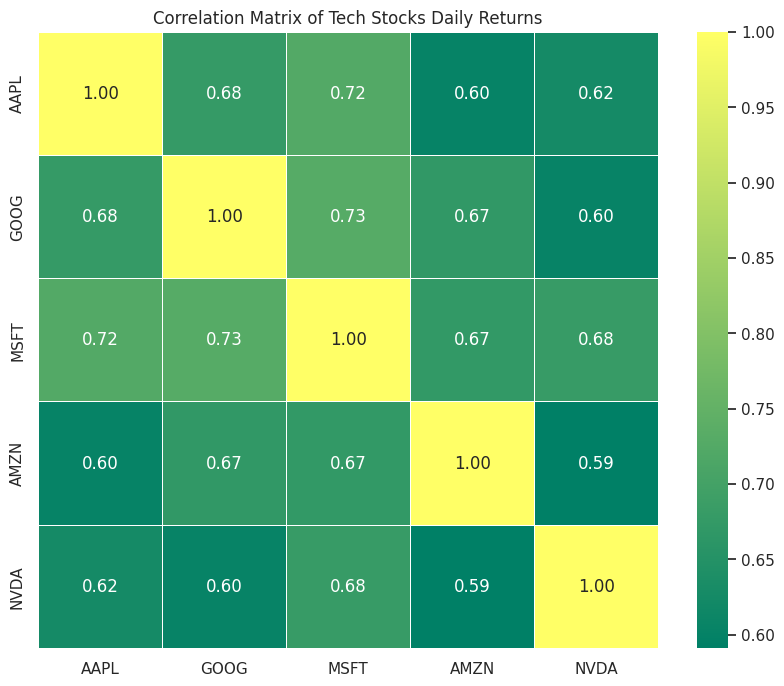

In [27]:
# Calculate daily returns for each stock
tech_daily_returns = tech_closing_prices.pct_change() * 100

# Calculate the correlation matrix
correlation_matrix = tech_daily_returns.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='summer', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Tech Stocks Daily Returns')
plt.show()

# Analysis of Expected Return and Standard Deviation of Daily Returns

In financial analysis, understanding the expected return and volatility of an investment is crucial for risk management and decision-making. In this analysis, we explore the distribution of daily returns, focusing on both the expected return and the standard deviation.

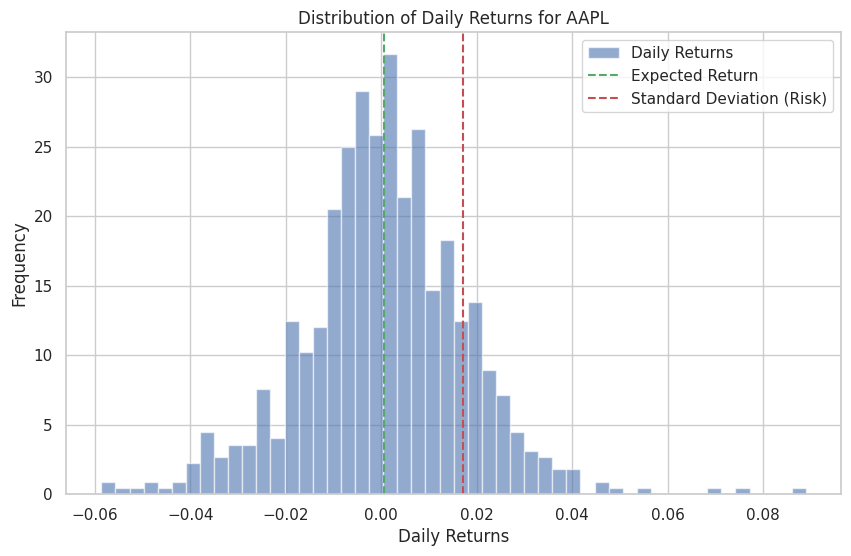

Expected Return for AAPL: 0.0006
Standard Deviation (Risk) for AAPL: 0.0172


In [28]:
# Function to fetch daily closing prices for a single stock
def load_closing_prices(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)['close']
    return df

# Load daily closing prices for a specific stock
stock_symbol = 'AAPL'
stock_prices = load_closing_prices(stock_symbol, start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns
daily_returns = stock_prices.pct_change().dropna()

# Calculate expected return and standard deviation of daily returns
expected_return = daily_returns.mean()
risk = daily_returns.std()

# Visualize the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(daily_returns, bins=50, density=True, alpha=0.6, color='b', label='Daily Returns')
plt.axvline(x=expected_return, color='g', linestyle='--', label='Expected Return')
plt.axvline(x=risk, color='r', linestyle='--', label='Standard Deviation (Risk)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title(f'Distribution of Daily Returns for {stock_symbol}')
plt.legend()
plt.show()

print(f'Expected Return for {stock_symbol}: {expected_return:.4f}')
print(f'Standard Deviation (Risk) for {stock_symbol}: {risk:.4f}')

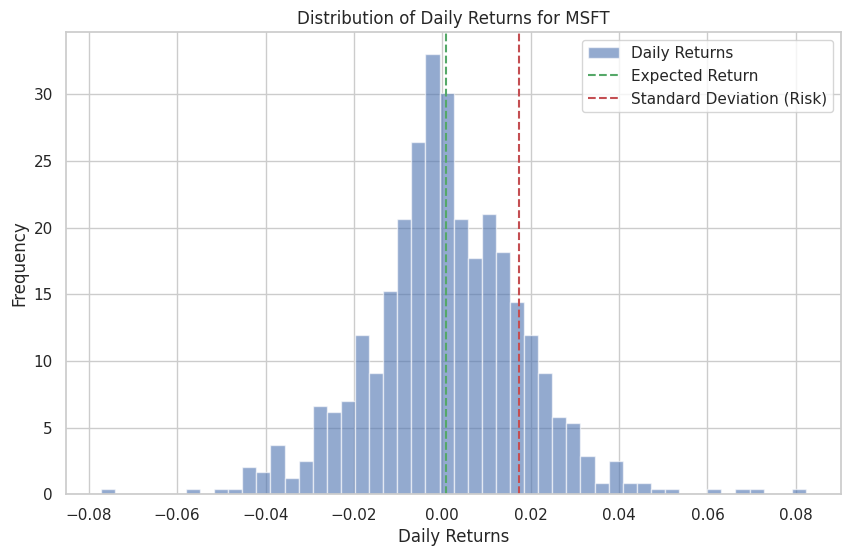

Expected Return for MSFT: 0.0008
Standard Deviation (Risk) for MSFT: 0.0174


In [29]:
# Function to fetch daily closing prices for a single stock
def load_closing_prices(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)['close']
    return df

# Load daily closing prices for a specific stock
stock_symbol = 'MSFT'
stock_prices = load_closing_prices(stock_symbol, start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns
daily_returns = stock_prices.pct_change().dropna()

# Calculate expected return and standard deviation of daily returns
expected_return = daily_returns.mean()
risk = daily_returns.std()

# Visualize the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(daily_returns, bins=50, density=True, alpha=0.6, color='b', label='Daily Returns')
plt.axvline(x=expected_return, color='g', linestyle='--', label='Expected Return')
plt.axvline(x=risk, color='r', linestyle='--', label='Standard Deviation (Risk)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title(f'Distribution of Daily Returns for {stock_symbol}')
plt.legend()
plt.show()

print(f'Expected Return for {stock_symbol}: {expected_return:.4f}')
print(f'Standard Deviation (Risk) for {stock_symbol}: {risk:.4f}')

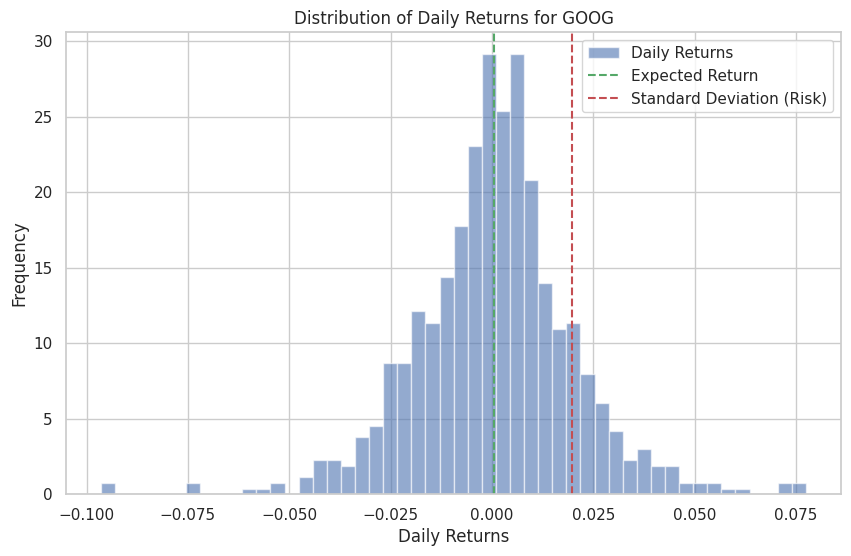

Expected Return for GOOG: 0.0006
Standard Deviation (Risk) for GOOG: 0.0197


In [30]:
# Function to fetch daily closing prices for a single stock
def load_closing_prices(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)['close']
    return df

# Load daily closing prices for a specific stock
stock_symbol = 'GOOG'
stock_prices = load_closing_prices(stock_symbol, start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns
daily_returns = stock_prices.pct_change().dropna()

# Calculate expected return and standard deviation of daily returns
expected_return = daily_returns.mean()
risk = daily_returns.std()

# Visualize the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(daily_returns, bins=50, density=True, alpha=0.6, color='b', label='Daily Returns')
plt.axvline(x=expected_return, color='g', linestyle='--', label='Expected Return')
plt.axvline(x=risk, color='r', linestyle='--', label='Standard Deviation (Risk)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title(f'Distribution of Daily Returns for {stock_symbol}')
plt.legend()
plt.show()

print(f'Expected Return for {stock_symbol}: {expected_return:.4f}')
print(f'Standard Deviation (Risk) for {stock_symbol}: {risk:.4f}')

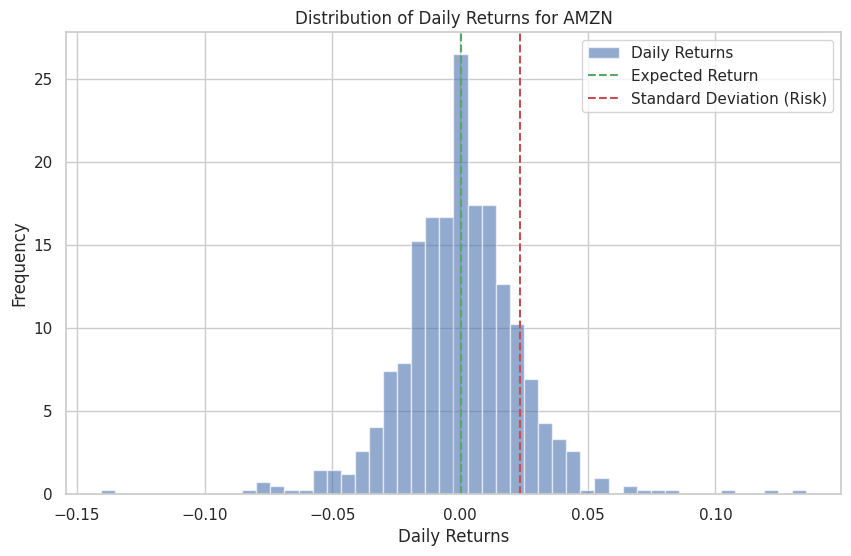

Expected Return for AMZN: 0.0004
Standard Deviation (Risk) for AMZN: 0.0236


In [31]:
# Function to fetch daily closing prices for a single stock
def load_closing_prices(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)['close']
    return df

# Load daily closing prices for a specific stock
stock_symbol = 'AMZN'
stock_prices = load_closing_prices(stock_symbol, start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns
daily_returns = stock_prices.pct_change().dropna()

# Calculate expected return and standard deviation of daily returns
expected_return = daily_returns.mean()
risk = daily_returns.std()

# Visualize the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(daily_returns, bins=50, density=True, alpha=0.6, color='b', label='Daily Returns')
plt.axvline(x=expected_return, color='g', linestyle='--', label='Expected Return')
plt.axvline(x=risk, color='r', linestyle='--', label='Standard Deviation (Risk)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title(f'Distribution of Daily Returns for {stock_symbol}')
plt.legend()
plt.show()

print(f'Expected Return for {stock_symbol}: {expected_return:.4f}')
print(f'Standard Deviation (Risk) for {stock_symbol}: {risk:.4f}')

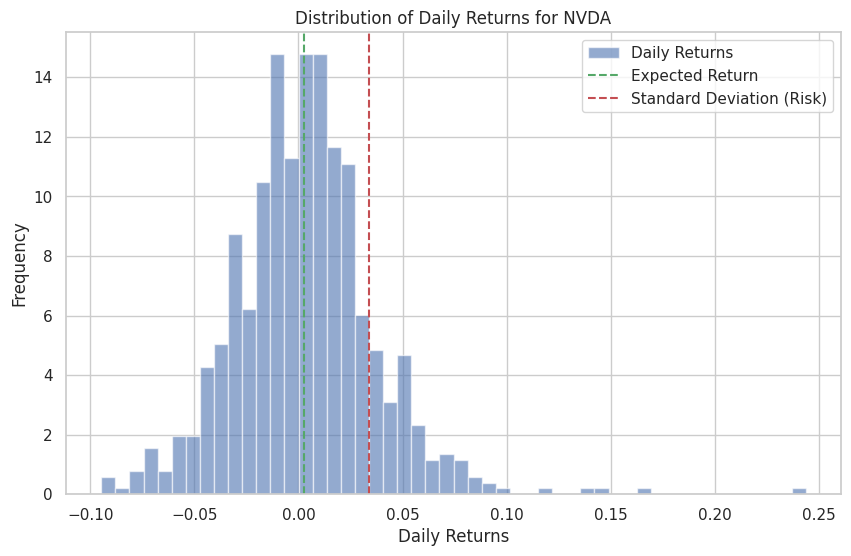

Expected Return for NVDA: 0.0027
Standard Deviation (Risk) for NVDA: 0.0337


In [32]:
# Function to fetch daily closing prices for a single stock
def load_closing_prices(stock, start_date, end_date, interval='1d'):
    df = si.get_data(stock, start_date=start_date, end_date=end_date, interval=interval)['close']
    return df

# Load daily closing prices for a specific stock
stock_symbol = 'NVDA'
stock_prices = load_closing_prices(stock_symbol, start_date=date_3_years_back, end_date=date_now)

# Calculate daily returns
daily_returns = stock_prices.pct_change().dropna()

# Calculate expected return and standard deviation of daily returns
expected_return = daily_returns.mean()
risk = daily_returns.std()

# Visualize the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(daily_returns, bins=50, density=True, alpha=0.6, color='b', label='Daily Returns')
plt.axvline(x=expected_return, color='g', linestyle='--', label='Expected Return')
plt.axvline(x=risk, color='r', linestyle='--', label='Standard Deviation (Risk)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title(f'Distribution of Daily Returns for {stock_symbol}')
plt.legend()
plt.show()

print(f'Expected Return for {stock_symbol}: {expected_return:.4f}')
print(f'Standard Deviation (Risk) for {stock_symbol}: {risk:.4f}')

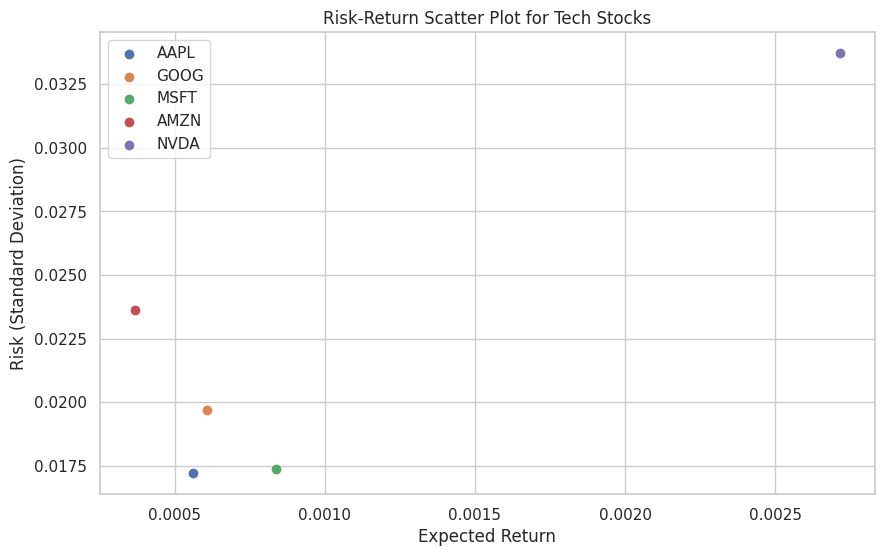

In [33]:
# Function to calculate expected return and risk for a stock
def calculate_risk_and_return(stock_prices):
    daily_returns = stock_prices.pct_change().dropna()
    expected_return = daily_returns.mean()
    risk = daily_returns.std()
    return expected_return, risk

# Load daily closing prices and calculate risk and return for each stock
stock_data = {}
for stock_symbol in STOCK_LIST:
    stock_prices = load_closing_prices(stock_symbol, start_date=date_3_years_back, end_date=date_now)
    expected_return, risk = calculate_risk_and_return(stock_prices)
    stock_data[stock_symbol] = {'Expected Return': expected_return, 'Risk': risk}

# Visualize the scatter plot
plt.figure(figsize=(10, 6))
for stock_symbol, data in stock_data.items():
    plt.scatter(data['Expected Return'], data['Risk'], label=stock_symbol)

plt.xlabel('Expected Return')
plt.ylabel('Risk (Standard Deviation)')
plt.title('Risk-Return Scatter Plot for Tech Stocks')
plt.legend()
plt.show()

# Predicting the closing price stock price of AMZN inc:

In [34]:
init_df = amazon_stocks.drop(['open', 'high', 'low', 'adjclose', 'volume','MA10', 'MA20', 'MA50', 'MA200', 'Daily_Return'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index
init_df

,close,ticker,date
2021-02-16,163.447495,AMZN,2021-02-16
2021-02-17,165.432007,AMZN,2021-02-17
2021-02-18,166.411499,AMZN,2021-02-18
2021-02-19,162.494995,AMZN,2021-02-19
2021-02-22,159.037003,AMZN,2021-02-22
...,...,...,...
2024-02-16,169.509995,AMZN,2024-02-16
2024-02-20,167.080002,AMZN,2024-02-20
2024-02-21,168.589996,AMZN,2024-02-21
2024-02-22,174.580002,AMZN,2024-02-22


In [35]:
# Calculate short and long EMAs for MACD
init_df['short_ema'] = init_df['close'].ewm(span=12, adjust=False).mean()
init_df['long_ema'] = init_df['close'].ewm(span=26, adjust=False).mean()

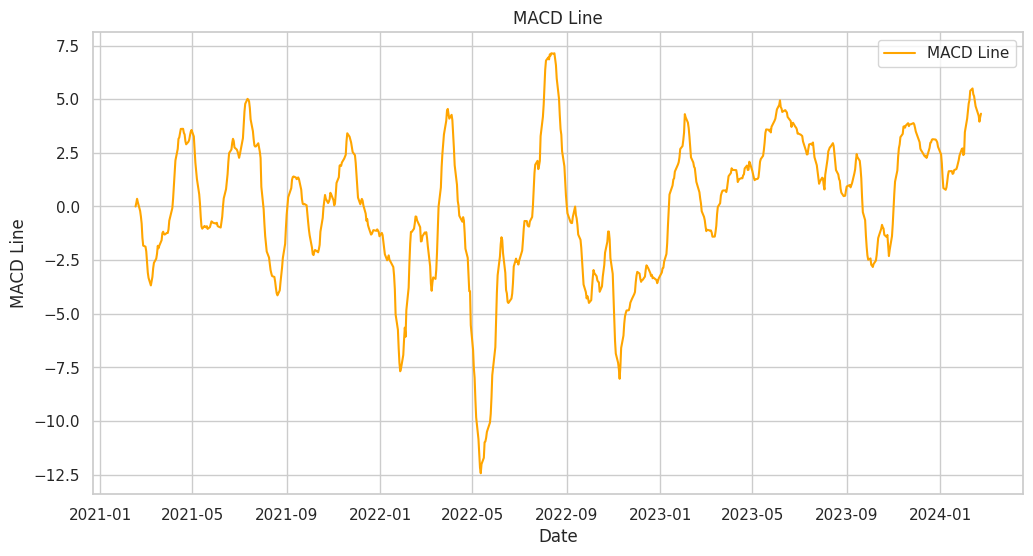

In [36]:
# Calculate MACD line
init_df['macd_line'] = init_df['short_ema'] - init_df['long_ema']

# Plot the MACD line (optional)
plt.figure(figsize=(12, 6))
plt.plot(init_df['date'], init_df['macd_line'], label='MACD Line', color='orange')
plt.title('MACD Line')
plt.xlabel('Date')
plt.ylabel('MACD Line')
plt.legend()
plt.show()

In [37]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
init_df

,close,ticker,date,short_ema,long_ema,macd_line,scaled_close
2021-02-16,163.447495,AMZN,2021-02-16,163.447495,163.447495,0.000000,0.779256
2021-02-17,165.432007,AMZN,2021-02-17,163.752804,163.594495,0.158309,0.798202
2021-02-18,166.411499,AMZN,2021-02-18,164.161834,163.803162,0.358672,0.807552
2021-02-19,162.494995,AMZN,2021-02-19,163.905397,163.706261,0.199136,0.770163
2021-02-22,159.037003,AMZN,2021-02-22,163.156414,163.360390,-0.203977,0.737152
...,...,...,...,...,...,...,...
2024-02-16,169.509995,AMZN,2024-02-16,168.307736,163.634907,4.672828,0.837132
2024-02-20,167.080002,AMZN,2024-02-20,168.118854,163.890099,4.228754,0.813934
2024-02-21,168.589996,AMZN,2024-02-21,168.191337,164.238240,3.953097,0.828349
2024-02-22,174.580002,AMZN,2024-02-22,169.174209,165.004296,4.169912,0.885533


In [38]:
# Scale MACD line for ML engine
macd_values = init_df['macd_line'].values.reshape(-1, 1)

macd_scaler = MinMaxScaler()
scaled_macd_values = macd_scaler.fit_transform(macd_values)

init_df['scaled_macd'] = scaled_macd_values

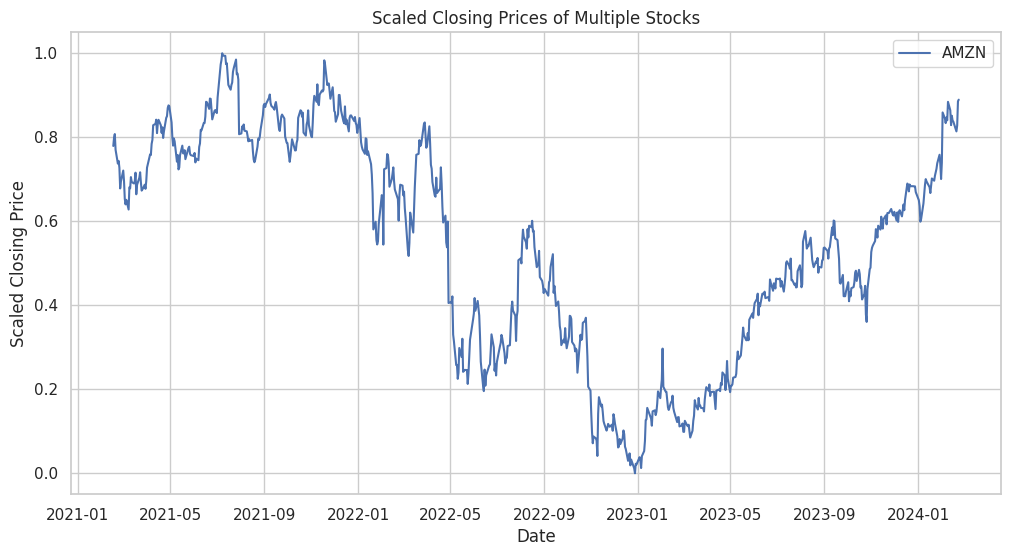

In [39]:
# Extract the closing prices for scaling
closing_prices = init_df['close'].values.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the closing prices using MinMaxScaler
scaled_closing_prices = scaler.fit_transform(closing_prices)

# Create a DataFrame with the scaled closing prices
scaled_df = init_df.copy()
scaled_df['scaled_close'] = scaled_closing_prices

# Plot the scaled closing prices
plt.figure(figsize=(12, 6))
for stock_symbol in scaled_df['ticker'].unique():
    stock_data = scaled_df[scaled_df['ticker'] == stock_symbol]
    plt.plot(stock_data['date'], stock_data['scaled_close'], label=stock_symbol)

plt.title('Scaled Closing Prices of Multiple Stocks')
plt.xlabel('Date')
plt.ylabel('Scaled Closing Price')
plt.legend()
plt.show()

In [40]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close', 'scaled_macd']].tail(days))
  df.dropna(inplace=True)

  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close', 'scaled_macd'] + ['date']].values, df['future'].values):
    sequences.append(entry)
    if len(sequences) == N_STEPS:
      sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close', 'scaled_macd'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
    X.append(seq)
    Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [41]:
PrepareData(3)

(                 close ticker       date   short_ema    long_ema  macd_line  \
 2021-02-16  163.447495   AMZN 2021-02-16  163.447495  163.447495   0.000000   
 2021-02-17  165.432007   AMZN 2021-02-17  163.752804  163.594495   0.158309   
 2021-02-18  166.411499   AMZN 2021-02-18  164.161834  163.803162   0.358672   
 2021-02-19  162.494995   AMZN 2021-02-19  163.905397  163.706261   0.199136   
 2021-02-22  159.037003   AMZN 2021-02-22  163.156414  163.360390  -0.203977   
 ...                ...    ...        ...         ...         ...        ...   
 2024-02-13  168.639999   AMZN 2024-02-13  167.195911  161.966420   5.229491   
 2024-02-14  170.979996   AMZN 2024-02-14  167.778078  162.634092   5.143986   
 2024-02-15  169.800003   AMZN 2024-02-15  168.089143  163.164900   4.924243   
 2024-02-16  169.509995   AMZN 2024-02-16  168.307736  163.634907   4.672828   
 2024-02-20  167.080002   AMZN 2024-02-20  168.118854  163.890099   4.228754   
 
             scaled_close  scaled_macd

In [42]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  # Combine scaled closing price and scaled MACD as input
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close', 'scaled_macd']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss=Huber(), optimizer='adam')

  model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1)

  model.summary()

  return model

In [43]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close', 'scaled_macd'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 6s 10ms/step - loss: 0.0119
Epoch 2/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0035
Epoch 3/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0029
Epoch 4/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 5/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0025
Epoch 6/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0027
Epoch 7/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 8/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 9/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 10/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0023
Epoch 11/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 12/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 13/80
95/95 [==================

In [44]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK_LIST[3]} prediction for upcoming 4 days ({predictions_str})'

  print(message)

AMZN prediction for upcoming 4 days (173.93$, 168.5$, 170.69$)


In [45]:
# init_df = init_df.drop(['ticker'], axis = 1)

In [46]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 5ms/step


In [47]:
copy_df

,close,ticker,date,short_ema,long_ema,macd_line,scaled_close,scaled_macd,predicted_close
2021-02-16,163.447495,AMZN,2021-02-16,163.447495,163.447495,0.000000,0.779256,0.635140,157.307007
2021-02-17,165.432007,AMZN,2021-02-17,163.752804,163.594495,0.158309,0.798202,0.643229,154.726501
2021-02-18,166.411499,AMZN,2021-02-18,164.161834,163.803162,0.358672,0.807552,0.653465,150.250000
2021-02-19,162.494995,AMZN,2021-02-19,163.905397,163.706261,0.199136,0.770163,0.645314,148.878494
2021-02-22,159.037003,AMZN,2021-02-22,163.156414,163.360390,-0.203977,0.737152,0.624719,150.022995
...,...,...,...,...,...,...,...,...,...
2024-02-16,169.509995,AMZN,2024-02-16,168.307736,163.634907,4.672828,0.837132,0.873881,165.888290
2024-02-20,167.080002,AMZN,2024-02-20,168.118854,163.890099,4.228754,0.813934,0.851193,164.159866
2024-02-21,168.589996,AMZN,2024-02-21,168.191337,164.238240,3.953097,0.828349,0.837109,168.589996
2024-02-22,174.580002,AMZN,2024-02-22,169.174209,165.004296,4.169912,0.885533,0.848186,174.580002


In [48]:
# Add predicted results to the table
date_now = pd.Timestamp(dt.date.today())
date_tomorrow = pd.Timestamp(dt.date.today() + dt.timedelta(days=1))
date_after_tomorrow = pd.Timestamp(dt.date.today() + dt.timedelta(days=2))

copy_df.loc[date_now] = [predictions[0], 0, f'{date_now.date()}', 0, 0, 0, 0, 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], 0, f'{date_tomorrow.date()}', 0, 0, 0, 0, 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], 0, f'{date_after_tomorrow.date()}', 0, 0, 0, 0, 0, 0]

Step 1:


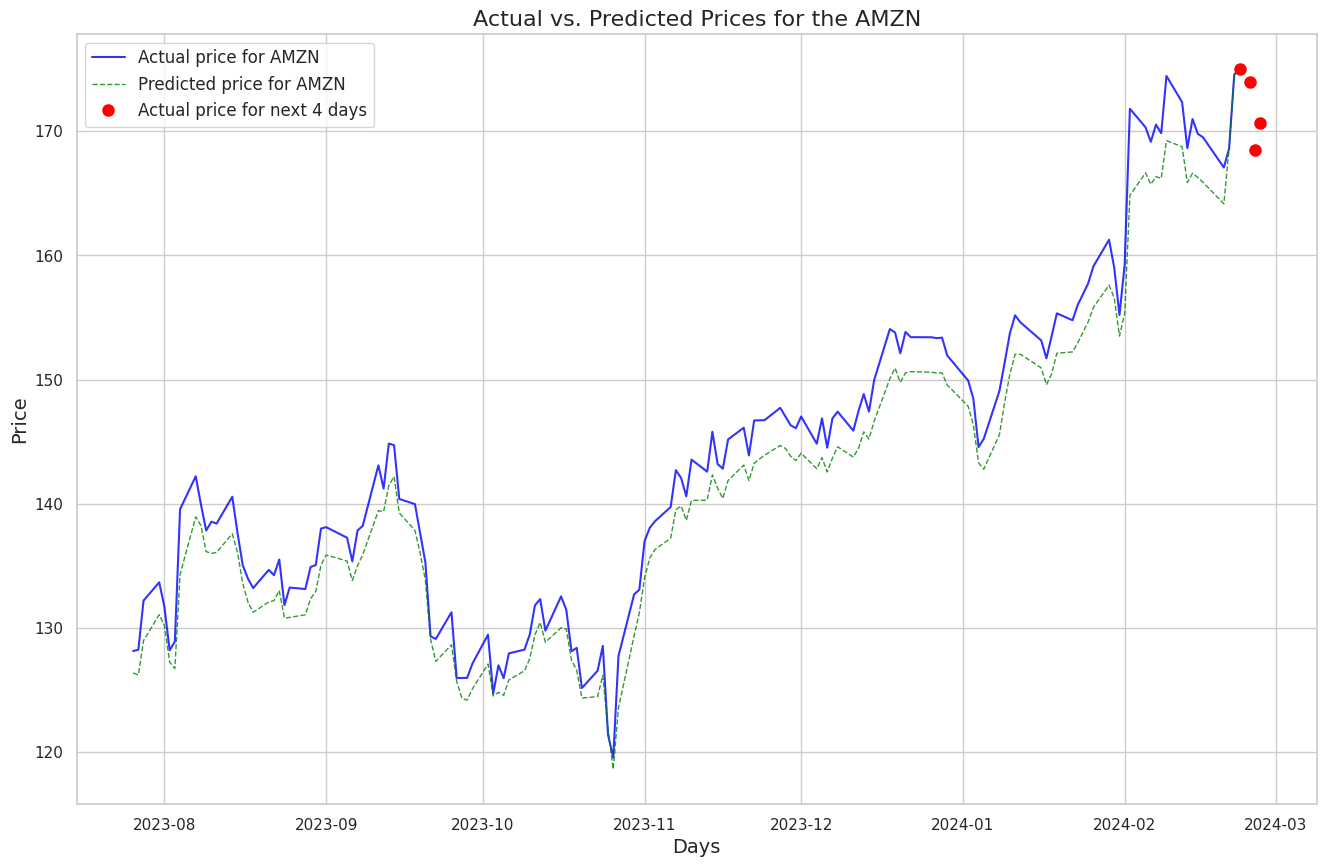

In [49]:
# Set the seaborn style
sns.set(style='whitegrid')

# Set the figure size
plt.figure(figsize=(16, 10))

# Plot actual price
plt.plot(copy_df['close'][-150:].head(147), label=f'Actual price for AMZN', color='blue', alpha=0.8)

# Plot predicted price with dashed line
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed', label=f'Predicted price for AMZN', color='green', alpha=0.8)

# Plot actual price for the last 3 days with different marker style
plt.plot(copy_df['close'][-150:].tail(4), marker='o', linestyle='None', markersize=8, label=f'Actual price for next 4 days', color='red')

# Set labels and legend
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title(f'Actual vs. Predicted Prices for the AMZN', fontsize=16)
plt.legend(fontsize=12)

# Show the plot
print("Step 1:")
plt.show()

In [50]:
predictions.append(round(float(predicted_price), 2))
# Get actual values for the corresponding predictions
actual_values = df['future'].tail(len(predictions)).values

# Calculate MSE, MAE, RMSE, and R2 Score
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
rmse = math.sqrt(mse)
r2 = r2_score(actual_values, predictions)

print(f"Step 2:")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
# print(f"R2 Score: {r2}")
print("\n")

Step 2:
MSE: 28937.18490687671
MAE: 170.09818421943507
RMSE: 170.10933221571565




RMSE for 10 days moving average: 5.70
MAE for 10 days moving average: 4.82
RMSE for 20 days moving average: 7.59
MAE for 20 days moving average: 6.47
RMSE for 50 days moving average: 12.22
MAE for 50 days moving average: 10.99
Step 1:


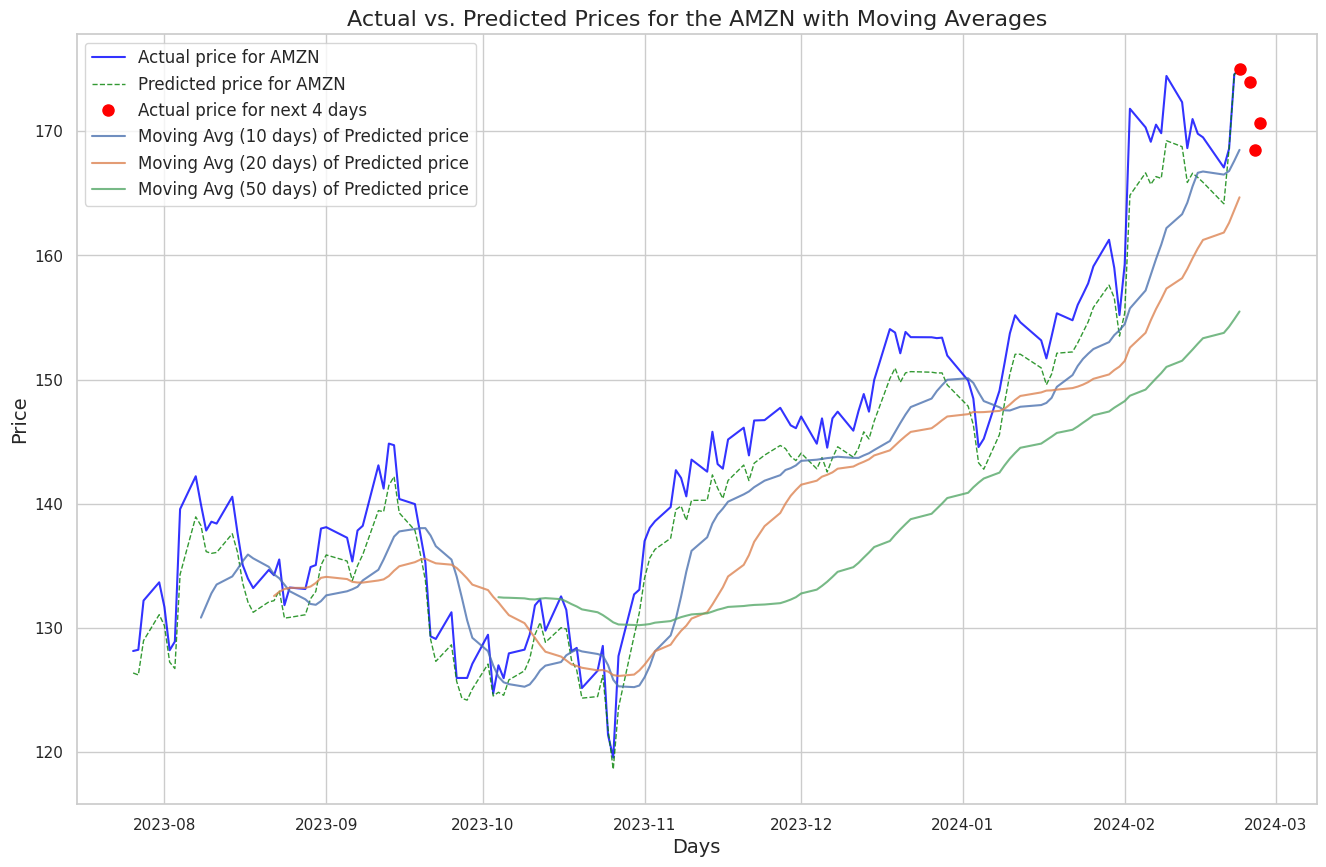

In [51]:
# Set the seaborn style
sns.set(style='whitegrid')

# Set the figure size
plt.figure(figsize=(16, 10))

# Plot actual price
actual_values = copy_df['close'][-150:].head(147)
plt.plot(actual_values, label='Actual price for AMZN', color='blue', alpha=0.8)

# Plot predicted price with dashed line
predicted_values = copy_df['predicted_close'][-150:].head(147)
plt.plot(predicted_values, linewidth=1, linestyle='dashed', label='Predicted price for AMZN', color='green', alpha=0.8)

# Plot actual price for the last 3 days with different marker style
plt.plot(copy_df['close'][-150:].tail(4), marker='o', linestyle='None', markersize=8, label='Actual price for next 4 days', color='red')

# Calculate and plot moving averages for predicted values
for window_size in [10, 20, 50, 200]:
    if len(predicted_values) >= window_size:
        predicted_avg = predicted_values.rolling(window=window_size).mean()
        plt.plot(predicted_avg, label=f'Moving Avg ({window_size} days) of Predicted price', alpha=0.8)

        # Calculate RMSE and MAE for each moving average
        rmse = np.sqrt(mean_squared_error(actual_values[window_size-1:], predicted_avg.dropna()))
        mae = mean_absolute_error(actual_values[window_size-1:], predicted_avg.dropna())
        print(f"RMSE for {window_size} days moving average: {rmse:.2f}")
        print(f"MAE for {window_size} days moving average: {mae:.2f}")

# Set labels and legend
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted Prices for the AMZN with Moving Averages', fontsize=16)
plt.legend(fontsize=12)

# Show the plot
print("Step 1:")
plt.show()